# Milestone 2: baseline models
___

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models, evaluate
from importlib import reload
reload(import_preprocess)
reload(baseline_models)
reload(evaluate)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int
from baseline_models import XGBoostClassifier, MajorityClassClassifier, RuleBasedClassifier, NaiveBayesClassifier, LogisticRegression, LSTM_Model, get_all_predictions

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train
X_val, y_val, S_val = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val
X_test, y_test, S_test = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test
X_balanced, y_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


In [4]:
# import_preprocess.convert_class_labels()
# y_train, y_dev, y_test = import_preprocess.y_train, import_preprocess.y_dev, import_preprocess.y_test

In [3]:
#X_train_dev, y_train_val = import_preprocess.concatenate_train_val()
#len(X_train_dev)
S_train[1]

'This is like the Metallica video where the poor mutilated bastard was saying "Please kill me" over and over again, only with emojis instead of Morse code.'

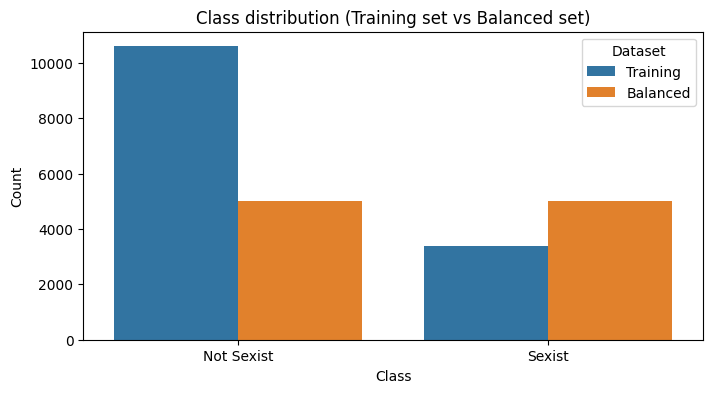

In [3]:
plot_data = pd.DataFrame({
    'Class': ['Not Sexist', 'Sexist'],
    'Training': [y_train.count('not sexist'), y_train.count('sexist')],
    'Balanced': [y_balanced.count('not sexist'), y_balanced.count('sexist')]
})
plot_data_melted = plot_data.melt(id_vars='Class', var_name='Dataset', value_name='Count')
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', hue='Dataset', data=plot_data_melted)
plt.title('Class distribution (Training set vs Balanced set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [4]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### a) Traditional (non-DL) baseline models

1. majority class classifier

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.7573
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



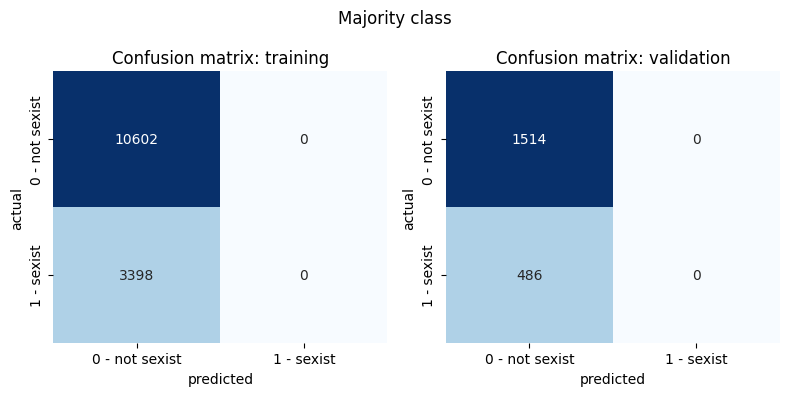

In [5]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.train(None, y_train, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="Majority class")
for res_x in res:
    results.loc[len(results)] = res_x

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.5000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



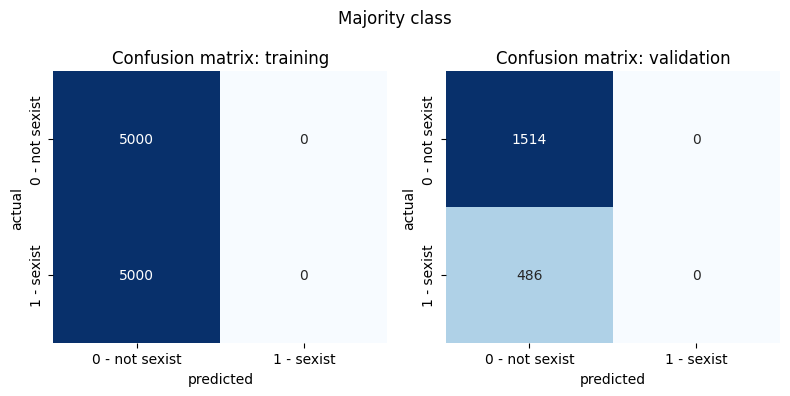

In [6]:
majority_class_classifier.train(None, y_balanced, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="Majority class")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

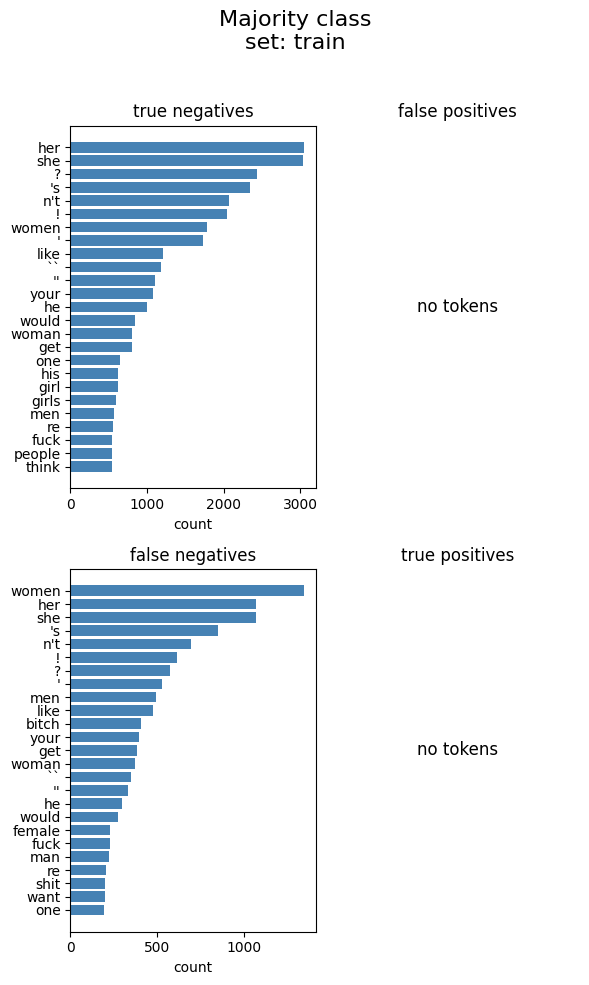

In [7]:
majority_class_classifier.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="Majority class", plot=True)

2. regex classifier (rule-based)

########################################

Metrics for training
accuracy: 0.7164
balanced accuracy: 0.5732
precision: 0.3890
recall: 0.2949

########################################

Metrics for validation
accuracy: 0.7075
balanced accuracy: 0.5630
precision: 0.3673
recall: 0.2819

########################################



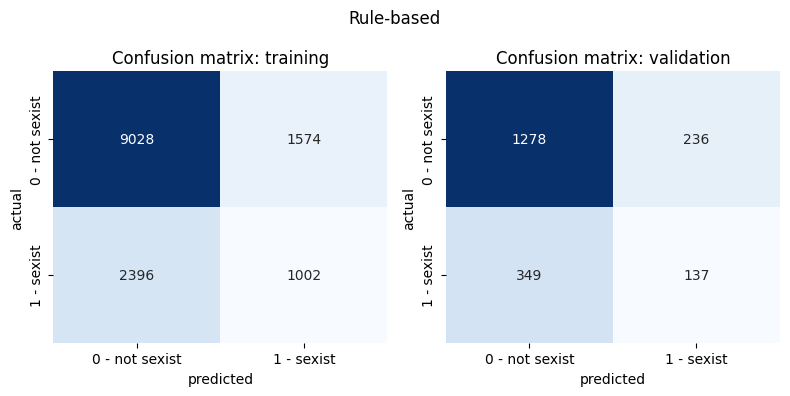

In [9]:
patterns = [
    r"\b(slut|bitch|fuck|fucking|sex)\b",
    r"\b(she has|she has to|she must|she shouldn't|women have to|women must|women shouldn't)\b",
    r"\b(hate|die)\b"
]

regex_classifier = RuleBasedClassifier(patterns)
res = regex_classifier.evaluate({"training": S_train, "validation": S_val}, [y_train, y_val], model_name="Rule-based")
for res_x in res:
    results.loc[len(results)] = res_x

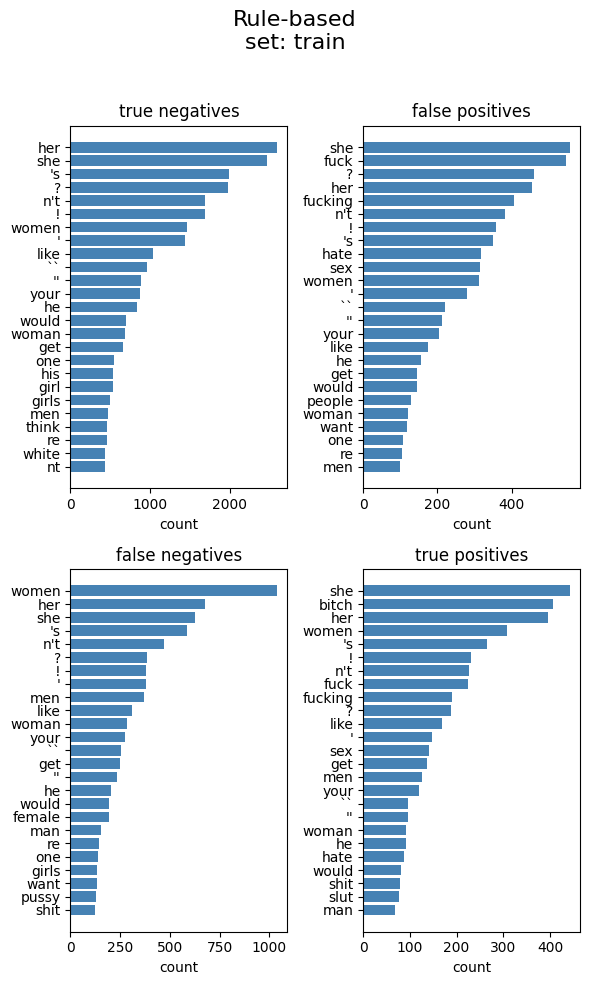

In [10]:
regex_classifier.qualitative_analysis_top_tokens(X_train, S_train, y_train, set_type="train", model_name="Rule-based", plot=True)

3. Naive Bayes (NB)

########################################

Metrics for training
accuracy: 0.8650
balanced accuracy: 0.7943
precision: 0.7551
recall: 0.6569

########################################

Metrics for validation
accuracy: 0.8155
balanced accuracy: 0.7140
precision: 0.6519
recall: 0.5165

########################################



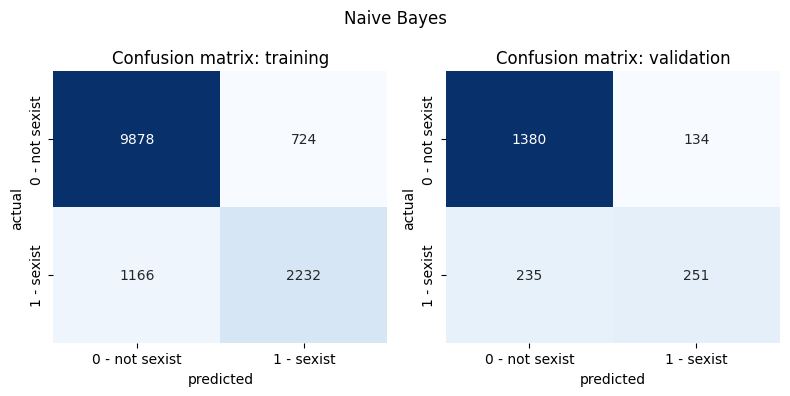

In [11]:
X_train_bow, X_val_bow, X_test_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x

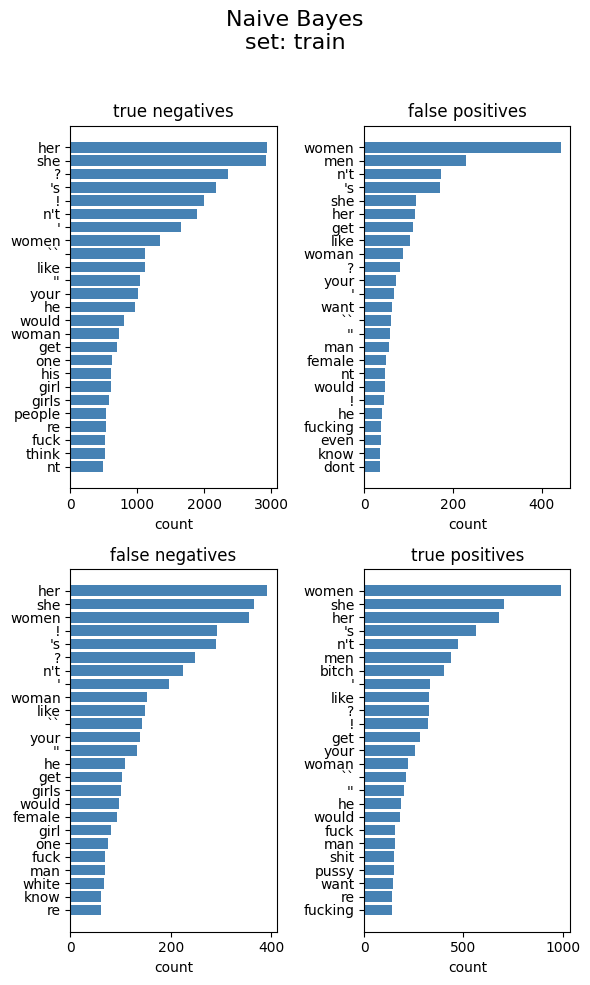

In [12]:
naive_bayes_classifier.qualitative_analysis_top_tokens(X_train, X_train_bow, y_train, set_type="train", model_name="Naive Bayes", plot=True)

In [17]:
top_tn_tokens, top_fp_tokens, top_fn_tokens, top_tp_tokens = \
    naive_bayes_classifier.qualitative_analysis_top_tokens(
        X_train, X_train_bow, y_train, set_type="train", 
        model_name="Naive Bayes", plot=False, top_n=50)

########################################

Metrics for training
accuracy: 0.8368
balanced accuracy: 0.8368
precision: 0.8257
recall: 0.8538

########################################

Metrics for validation
accuracy: 0.7195
balanced accuracy: 0.6974
precision: 0.4473
recall: 0.6543

########################################



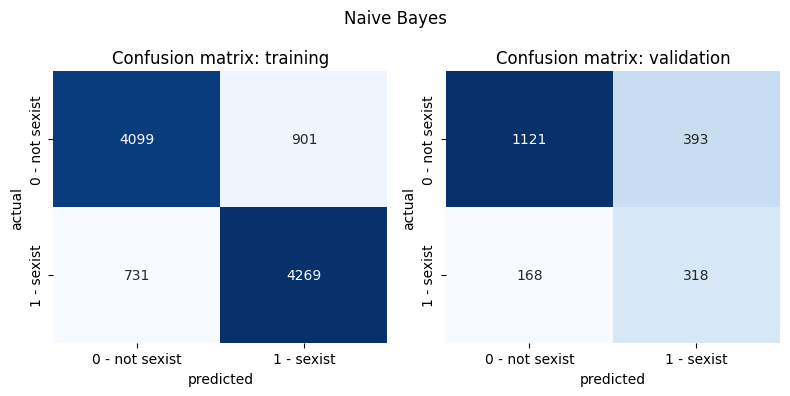

In [16]:
X_train_balanced_bow, X_val_balanced_bow, X_test_balanced_bow, X_train_val_balanced_bow, feature_names = import_preprocess.create_bow_representation(balanced=True)
naive_bayes_classifier.train(X_train_balanced_bow, y_balanced, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

4. Logisitic Regression

########################################

Metrics for training
accuracy: 0.8919
balanced accuracy: 0.8021
precision: 0.8955
recall: 0.6277

########################################

Metrics for validation
accuracy: 0.8310
balanced accuracy: 0.7081
precision: 0.7403
recall: 0.4691

########################################



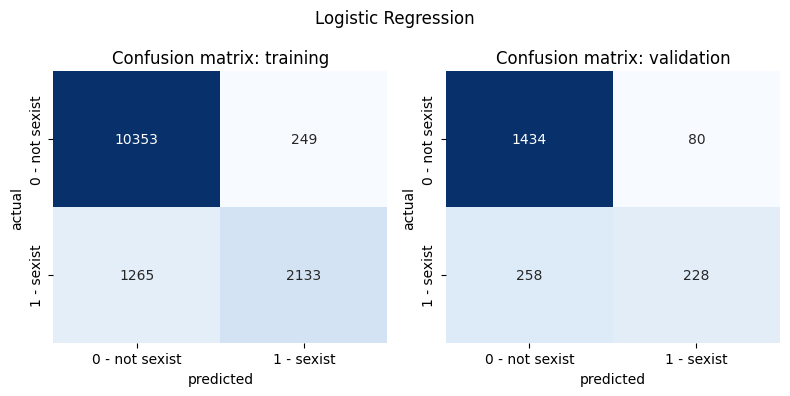

In [17]:
log_reg_classifier = LogisticRegression()
log_reg_classifier.train(X_train_bow, y_train, None, None)

res = log_reg_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Logistic Regression")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.9175
balanced accuracy: 0.9175
precision: 0.9254
recall: 0.9082

########################################

Metrics for validation
accuracy: 0.7020
balanced accuracy: 0.5433
precision: 0.3373
recall: 0.2346

########################################



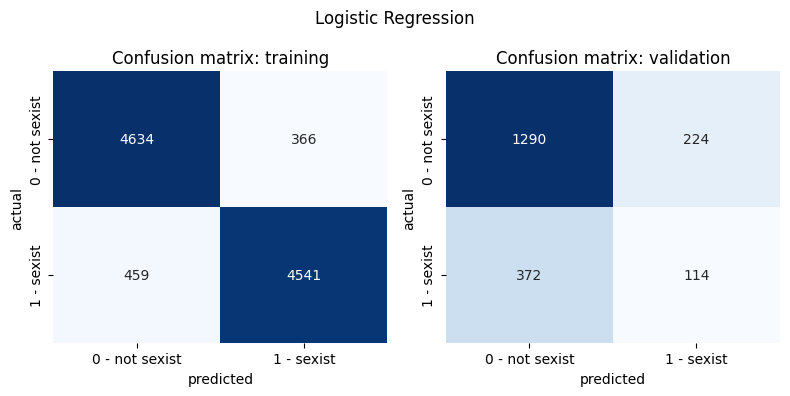

In [18]:
log_reg_classifier.train(X_train_balanced_bow, y_balanced, None, None)

res = log_reg_classifier.evaluate({"training": X_train_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="Logistic Regression")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (using BoW representation)

[0]	train-logloss:0.53009	eval-logloss:0.53454
[1]	train-logloss:0.51116	eval-logloss:0.51866
[2]	train-logloss:0.49586	eval-logloss:0.50590
[3]	train-logloss:0.48348	eval-logloss:0.49566
[4]	train-logloss:0.47308	eval-logloss:0.48727
[5]	train-logloss:0.46405	eval-logloss:0.48068
[6]	train-logloss:0.45658	eval-logloss:0.47452
[7]	train-logloss:0.44996	eval-logloss:0.47000
[8]	train-logloss:0.44414	eval-logloss:0.46612
[9]	train-logloss:0.43921	eval-logloss:0.46179
[10]	train-logloss:0.43483	eval-logloss:0.45844
[11]	train-logloss:0.43071	eval-logloss:0.45608
[12]	train-logloss:0.42720	eval-logloss:0.45407
[13]	train-logloss:0.42371	eval-logloss:0.45154
[14]	train-logloss:0.42068	eval-logloss:0.44925
[15]	train-logloss:0.41710	eval-logloss:0.44717
[16]	train-logloss:0.41453	eval-logloss:0.44600
[17]	train-logloss:0.41212	eval-logloss:0.44429
[18]	train-logloss:0.40972	eval-logloss:0.44285
[19]	train-logloss:0.40777	eval-logloss:0.44189
[20]	train-logloss:0.40607	eval-logloss:0.44081
[2

d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:47:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	train-logloss:0.40212	eval-logloss:0.43790
[23]	train-logloss:0.40026	eval-logloss:0.43648
[24]	train-logloss:0.39888	eval-logloss:0.43567
[25]	train-logloss:0.39726	eval-logloss:0.43473
[26]	train-logloss:0.39593	eval-logloss:0.43369
[27]	train-logloss:0.39367	eval-logloss:0.43252
[28]	train-logloss:0.39248	eval-logloss:0.43180
[29]	train-logloss:0.39044	eval-logloss:0.43083
[30]	train-logloss:0.38934	eval-logloss:0.42960
[31]	train-logloss:0.38797	eval-logloss:0.42863
[32]	train-logloss:0.38643	eval-logloss:0.42836
[33]	train-logloss:0.38514	eval-logloss:0.42758
[34]	train-logloss:0.38374	eval-logloss:0.42677
[35]	train-logloss:0.38182	eval-logloss:0.42626
[36]	train-logloss:0.38090	eval-logloss:0.42528
[37]	train-logloss:0.37976	eval-logloss:0.42438
[38]	train-logloss:0.37863	eval-logloss:0.42375
[39]	train-logloss:0.37725	eval-logloss:0.42305
[40]	train-logloss:0.37627	eval-logloss:0.42224
[41]	train-logloss:0.37548	eval-logloss:0.42184
[42]	train-logloss:0.37438	eval-logloss:

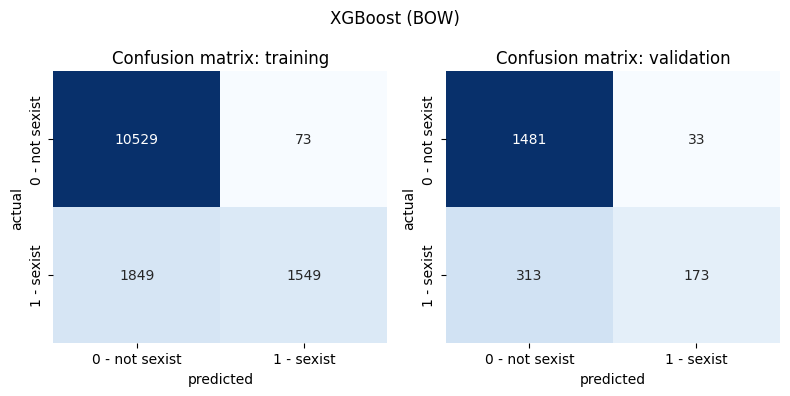

In [19]:
xg_boost_bow = XGBoostClassifier()
xg_boost_bow.train(X_train_bow, y_train, X_val_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66760	eval-logloss:0.67018
[1]	train-logloss:0.64652	eval-logloss:0.65126
[2]	train-logloss:0.62875	eval-logloss:0.63578
[3]	train-logloss:0.61419	eval-logloss:0.62270
[4]	train-logloss:0.60181	eval-logloss:0.61138
[5]	train-logloss:0.59091	eval-logloss:0.60162
[6]	train-logloss:0.58132	eval-logloss:0.59284
[7]	train-logloss:0.57305	eval-logloss:0.58549
[8]	train-logloss:0.56558	eval-logloss:0.57881
[9]	train-logloss:0.55930	eval-logloss:0.57304
[10]	train-logloss:0.55342	eval-logloss:0.56793
[11]	train-logloss:0.54810	eval-logloss:0.56338
[12]	train-logloss:0.54302	eval-logloss:0.55923
[13]	train-logloss:0.53841	eval-logloss:0.55547
[14]	train-logloss:0.53211	eval-logloss:0.55193
[15]	train-logloss:0.52810	eval-logloss:0.54842
[16]	train-logloss:0.52429	eval-logloss:0.54510
[17]	train-logloss:0.52114	eval-logloss:0.54235
[18]	train-logloss:0.51794	eval-logloss:0.53990
[19]	train-logloss:0.51517	eval-logloss:0.53740


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	train-logloss:0.51132	eval-logloss:0.53515
[21]	train-logloss:0.50761	eval-logloss:0.53295
[22]	train-logloss:0.50535	eval-logloss:0.53135
[23]	train-logloss:0.50321	eval-logloss:0.52932
[24]	train-logloss:0.50111	eval-logloss:0.52751
[25]	train-logloss:0.49898	eval-logloss:0.52600
[26]	train-logloss:0.49590	eval-logloss:0.52454
[27]	train-logloss:0.49424	eval-logloss:0.52281
[28]	train-logloss:0.49178	eval-logloss:0.52165
[29]	train-logloss:0.48904	eval-logloss:0.52002
[30]	train-logloss:0.48703	eval-logloss:0.51896
[31]	train-logloss:0.48408	eval-logloss:0.51793
[32]	train-logloss:0.48238	eval-logloss:0.51679
[33]	train-logloss:0.48081	eval-logloss:0.51535
[34]	train-logloss:0.47881	eval-logloss:0.51427
[35]	train-logloss:0.47754	eval-logloss:0.51296
[36]	train-logloss:0.47572	eval-logloss:0.51161
[37]	train-logloss:0.47421	eval-logloss:0.51050
[38]	train-logloss:0.47257	eval-logloss:0.50991
[39]	train-logloss:0.47009	eval-logloss:0.50854
[40]	train-logloss:0.46863	eval-logloss:

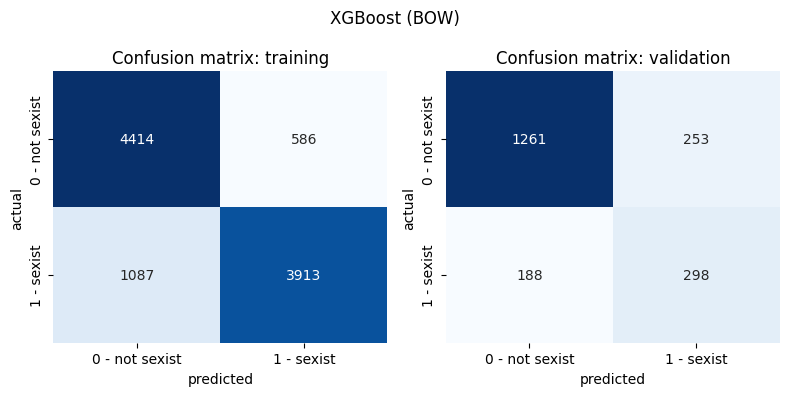

In [20]:
xg_boost_bow.train(X_train_balanced_bow, y_balanced, X_val_balanced_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (TF-IDF representation)

d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.52958	eval-logloss:0.53394
[1]	train-logloss:0.51006	eval-logloss:0.51771
[2]	train-logloss:0.49477	eval-logloss:0.50527
[3]	train-logloss:0.48208	eval-logloss:0.49567
[4]	train-logloss:0.47150	eval-logloss:0.48764
[5]	train-logloss:0.46256	eval-logloss:0.48115
[6]	train-logloss:0.45455	eval-logloss:0.47554
[7]	train-logloss:0.44794	eval-logloss:0.47048
[8]	train-logloss:0.44167	eval-logloss:0.46661
[9]	train-logloss:0.43624	eval-logloss:0.46296
[10]	train-logloss:0.43158	eval-logloss:0.45925
[11]	train-logloss:0.42734	eval-logloss:0.45712
[12]	train-logloss:0.42351	eval-logloss:0.45468
[13]	train-logloss:0.42008	eval-logloss:0.45318
[14]	train-logloss:0.41695	eval-logloss:0.45141
[15]	train-logloss:0.41380	eval-logloss:0.44947
[16]	train-logloss:0.41114	eval-logloss:0.44779
[17]	train-logloss:0.40869	eval-logloss:0.44596
[18]	train-logloss:0.40639	eval-logloss:0.44461
[19]	train-logloss:0.40376	eval-logloss:0.44379
[20]	train-logloss:0.40192	eval-logloss:0.44245
[2

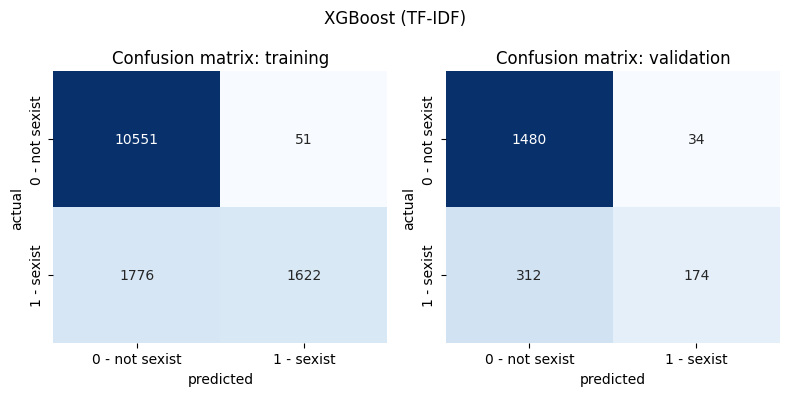

In [21]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, X_train_val_tfidf, feature_names = import_preprocess.create_tfidf_representation()

xg_boost_tfidf = XGBoostClassifier()
xg_boost_tfidf.train(X_train_tfidf, y_train, X_val_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_tfidf, "validation": X_val_tfidf}, [y_train, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66701	eval-logloss:0.67028


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-logloss:0.64510	eval-logloss:0.65112
[2]	train-logloss:0.62655	eval-logloss:0.63508
[3]	train-logloss:0.61100	eval-logloss:0.62217
[4]	train-logloss:0.59843	eval-logloss:0.61117
[5]	train-logloss:0.58618	eval-logloss:0.60073
[6]	train-logloss:0.57579	eval-logloss:0.59202
[7]	train-logloss:0.56700	eval-logloss:0.58480
[8]	train-logloss:0.55895	eval-logloss:0.57830
[9]	train-logloss:0.55240	eval-logloss:0.57268
[10]	train-logloss:0.54609	eval-logloss:0.56820
[11]	train-logloss:0.53967	eval-logloss:0.56420
[12]	train-logloss:0.53271	eval-logloss:0.56076
[13]	train-logloss:0.52746	eval-logloss:0.55706
[14]	train-logloss:0.52223	eval-logloss:0.55414
[15]	train-logloss:0.51800	eval-logloss:0.55067
[16]	train-logloss:0.51434	eval-logloss:0.54844
[17]	train-logloss:0.51098	eval-logloss:0.54579
[18]	train-logloss:0.50738	eval-logloss:0.54371
[19]	train-logloss:0.50435	eval-logloss:0.54168
[20]	train-logloss:0.50142	eval-logloss:0.53971
[21]	train-logloss:0.49871	eval-logloss:0.53735
[

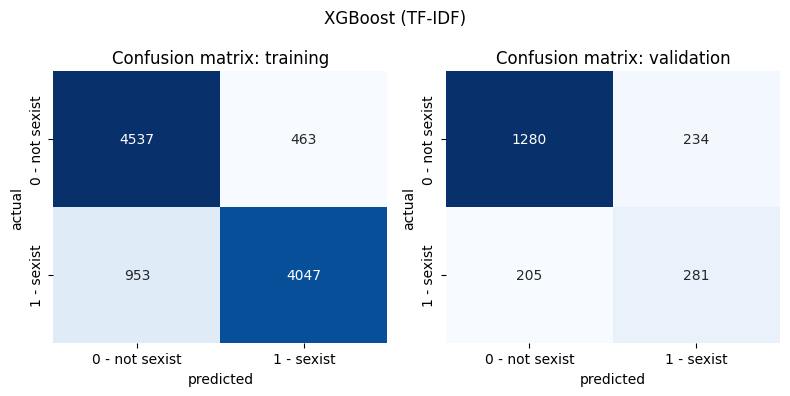

In [22]:
X_train_balanced_tfidf, X_val_balanced_tfidf, X_test_balanced_tfidf, X_train_val_balanced_tfidf, feature_names = import_preprocess.create_tfidf_representation(balanced=True)

xg_boost_tfidf.train(X_train_balanced_tfidf, y_balanced, X_val_balanced_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_balanced_tfidf, "validation": X_val_balanced_tfidf}, [y_balanced, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

#### b) DL baseline models

1. LSTM



Epoch 1/10


438/438 [==============================] - 8s 15ms/step - loss: 0.5344 - accuracy: 0.7645 - val_loss: 0.4893 - val_accuracy: 0.7780
Epoch 2/10
438/438 [==============================] - 6s 15ms/step - loss: 0.4242 - accuracy: 0.8217 - val_loss: 0.4235 - val_accuracy: 0.8205
Epoch 3/10
438/438 [==============================] - 6s 14ms/step - loss: 0.3494 - accuracy: 0.8597 - val_loss: 0.4546 - val_accuracy: 0.8225
Epoch 4/10
438/438 [==============================] - 6s 14ms/step - loss: 0.3102 - accuracy: 0.8816 - val_loss: 0.4055 - val_accuracy: 0.8335
Epoch 5/10
438/438 [==============================] - 6s 14ms/step - loss: 0.2769 - accuracy: 0.8971 - val_loss: 0.4112 - val_accuracy: 0.8250
Epoch 6/10
438/438 [==============================] - 6s 15ms/step - loss: 0.2492 - accuracy: 0.9116 - val_loss: 0.4630 - val_accuracy: 0.8155
Epoch 7/10
438/438 [==============================] - 7s 15ms/step - loss: 0.2257 - accuracy: 0.9236 - val_loss: 0.4415 - val_accuracy: 0.

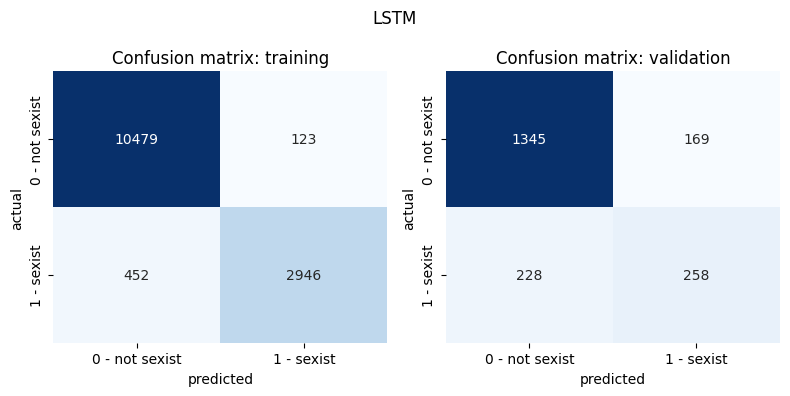

In [23]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

rnn = LSTM_Model()
rnn.train(X_train, y_train, X_val, y_val)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x

Epoch 1/10
313/313 [==============================] - 5s 14ms/step - loss: 0.6936 - accuracy: 0.5028 - val_loss: 0.6916 - val_accuracy: 0.7240
Epoch 2/10
313/313 [==============================] - 4s 13ms/step - loss: 0.6650 - accuracy: 0.5650 - val_loss: 0.5161 - val_accuracy: 0.7815
Epoch 3/10
313/313 [==============================] - 4s 14ms/step - loss: 0.4596 - accuracy: 0.7994 - val_loss: 0.4760 - val_accuracy: 0.7830
Epoch 4/10
313/313 [==============================] - 4s 14ms/step - loss: 0.3190 - accuracy: 0.8749 - val_loss: 0.5681 - val_accuracy: 0.7420
Epoch 5/10
313/313 [==============================] - 4s 13ms/step - loss: 0.2489 - accuracy: 0.9093 - val_loss: 0.6261 - val_accuracy: 0.7315
Epoch 6/10
313/313 [==============================] - 5s 14ms/step - loss: 0.2017 - accuracy: 0.9304 - val_loss: 0.5635 - val_accuracy: 0.7570
Epoch 7/10
313/313 [==============================] - 4s 14ms/step - loss: 0.1665 - accuracy: 0.9452 - val_loss: 0.5962 - val_accuracy: 0.7860

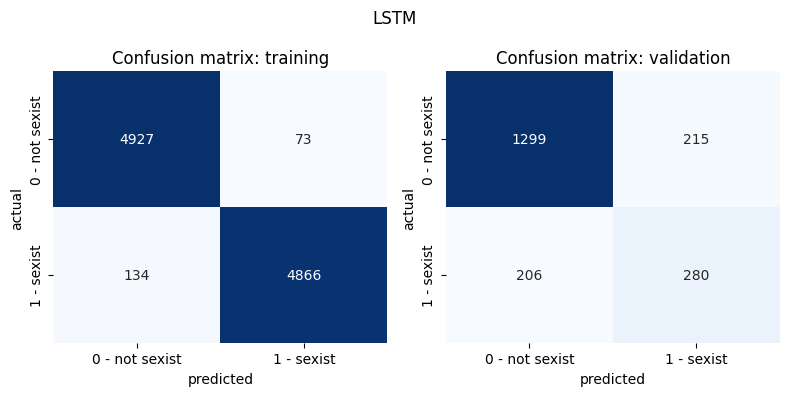

In [24]:
# y_train = convert_labels_to_int(y_train)
# y_balanced = convert_labels_to_int(y_balanced)
# y_val = convert_labels_to_int(y_val)
rnn.train(X_balanced, y_balanced, X_val, y_val)
res = rnn.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

438/438 [==============================] - 1s 3ms/step


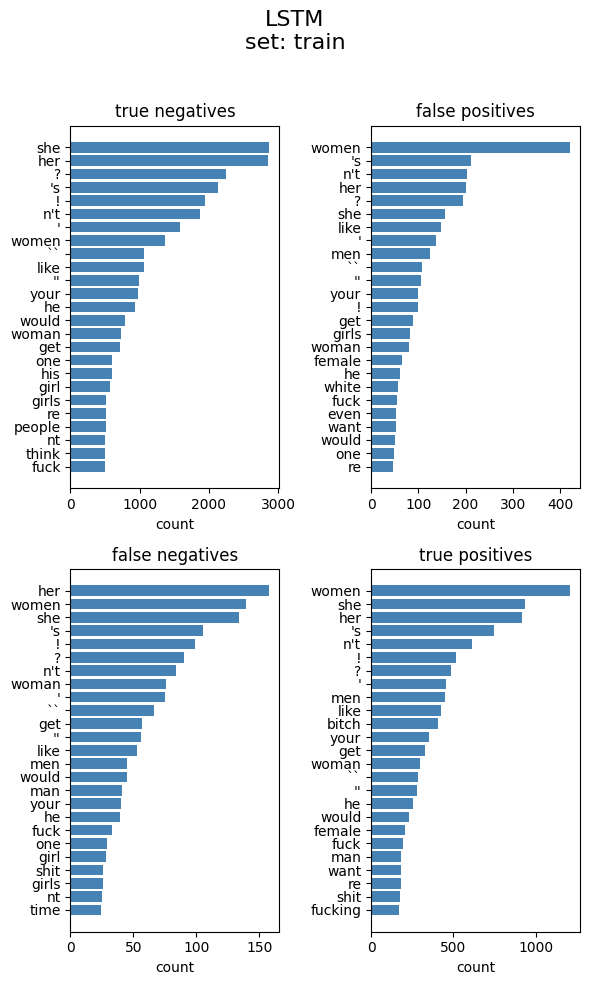

In [28]:
rnn.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="LSTM", plot=True)

## Results

In [29]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.757286,0.500000,0.000000,0.000000
1,Majority class,validation,0.757000,0.500000,0.000000,0.000000
2,Rule-based,training,0.716429,0.573208,0.388975,0.294879
3,Rule-based,validation,0.707500,0.563007,0.367292,0.281893
4,Naive Bayes,training,0.865000,0.794284,0.755074,0.656857
5,Naive Bayes,validation,0.815500,0.713977,0.651948,0.516461
6,Logistic Regression,training,0.891857,0.802118,0.895466,0.627722
7,Logistic Regression,validation,0.831000,0.708148,0.740260,0.469136
8,XGBoost (BOW),training,0.862714,0.724485,0.954994,0.455856
9,XGBoost (BOW),validation,0.827000,0.667085,0.839806,0.355967


In [30]:
balanced_results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.5000,0.500000,0.000000,0.000000
1,Majority class,validation,0.7570,0.500000,0.000000,0.000000
2,Naive Bayes,training,0.8368,0.836800,0.825725,0.853800
3,Naive Bayes,validation,0.7195,0.697372,0.447257,0.654321
4,Logistic Regression,training,0.9175,0.917500,0.925413,0.908200
5,Logistic Regression,validation,0.7020,0.543308,0.337278,0.234568
6,XGBoost (BOW),training,0.8327,0.832700,0.869749,0.782600
7,XGBoost (BOW),validation,0.7795,0.723031,0.540835,0.613169
8,XGBoost (TF-IDF),training,0.8584,0.858400,0.897339,0.809400
9,XGBoost (TF-IDF),validation,0.7805,0.711816,0.545631,0.578189


In [23]:
models_dict = {
    "Majority Class": majority_class_classifier,
    "Naive Bayes": naive_bayes_classifier,
    "Logistic Regression": log_reg_classifier,
    "XGBoost (BOW)": xg_boost_bow,
    "LSTM": rnn
}

predictions = get_all_predictions(models_dict, X_val[1], X_val_bow[1], y_val[1])

1/1 [==============================] - 0s 11ms/step


In [24]:
predictions

{'true': 'not sexist',
 'Majority Class': ['not sexist'],
 'Naive Bayes': array(['sexist'], dtype='<U10'),
 'Logistic Regression': array(['not sexist'], dtype='<U10'),
 'XGBoost (BOW)': ['not sexist'],
 'LSTM': 'not sexist'}

In [25]:
y_pred = rnn.predict(X_val)
y_pred = convert_labels_to_string(y_pred)
y_val = y_val if isinstance(y_val[0], str) else convert_labels_to_string(y_val)

false_negative_indices = [i for i in range(len(X_val)) if y_val[i] == 'sexist' and y_pred[i] == 'not sexist']
false_negative_sentences = [S_val[i] for i in false_negative_indices]
false_negative_sentences

63/63 [==============================] - 0s 3ms/step


['I agree with that but at the same time I know myself well enough to say I canâ\x80\x99t love a woman. The minute she begins to hit the wall and some hotter, younger women enters the picture, itâ\x80\x99s time for impulse control because Iâ\x80\x99m going to want that.',
 "aim for the head so she dosn't come back",
 "This guys gonna have a great time in the barracks. If they don't know who he is, they will the first time he takes a communal shower. Christ, the women Marines will even be giving him shit. Ooorah! Fuckin-A.",
 'until she\'s been around me long enough through real life situations where I can actually see who she really is Like observing her rage when the wifi connection is set to "shit-tier" on the router on purpose. ]=)',
 "I've only known 2 or 3 men in my entire life that micro managed their wives, girlfriends. It's exhausting and not worth it and most men are not that tiny, tiny minded, spiteful, hate filled and petty like a woman's mind is.",
 'Just block her, the dat

# Report on Misclassification Analysis of RNN Model

In [26]:
import random
random.seed(1234)
# Predict on the test set
y_pred_test = rnn.predict(X_test)

# Convert predictions and true labels to string format
y_pred_test = convert_labels_to_string(y_pred_test)
y_test = y_test if isinstance(y_test[0], str) else convert_labels_to_string(y_test)

# Identify indices for each confusion matrix quadrant
tp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'sexist']  # True Positives
tn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'not sexist']  # True Negatives
fp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'sexist']  # False Positives
fn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'not sexist']  # False Negatives

# Randomly sample up to 25 sentences from each quadrant
sampled_tp_test = random.sample(tp_indices_test, min(25, len(tp_indices_test)))
sampled_tn_test = random.sample(tn_indices_test, min(25, len(tn_indices_test)))
sampled_fp_test = random.sample(fp_indices_test, min(25, len(fp_indices_test)))
sampled_fn_test = random.sample(fn_indices_test, min(25, len(fn_indices_test)))

# Extract sentences for sampled indices
sampled_sentences_tp_test = [S_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test = [S_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test = [S_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test = [S_test[i] for i in sampled_fn_test]

# Print the sampled sentences for analysis
print("Sampled True Positives (TP):")
for sentence in sampled_sentences_tp_test:
    print(sentence)

print("\nSampled True Negatives (TN):")
for sentence in sampled_sentences_tn_test:
    print(sentence)

print("\nSampled False Positives (FP):")
for sentence in sampled_sentences_fp_test:
    print(sentence)

print("\nSampled False Negatives (FN):")
for sentence in sampled_sentences_fn_test:
    print(sentence)


125/125 [==============================] - 0s 4ms/step
Sampled True Positives (TP):
Miss Pony [USER] posting her own home made porn photos Your one sick bitch !
keep talking, hag
I'm sure that kinder gentler baboon troop was soon overtaken by the dump defenders troop with the young being massacred and the females being taken as spoils. Yeah, sounds pretty great.
Absolutely! If these RINOs stab US all in the back - tossing their vote to the Democrats = WE WILL NEVER FORGET! It's a hardcore SMEAR CAMPAIGN w Hillary Clinton and her lawyers behind it all = EVIL BITCH.
you have a women that smashes other people's heads into lockers. son you need to lose that bitch now! and you think that you are the only she got on a string.
she lowers her prices with kids. Hang the Pedo bitvch
courage precludes the wise and strong from prostrating to his base emotions. let the woman freak out. were cooler under pressure, so lets be cool under pressure. let the women attack us physically, were stronger. bei

## Overview
We are going into an in depth analysis of the RNN model's misclassifications on the test dataset for a sexism detection task. It categorizes the sentences into four confusion matrix quadrants:
- **True Positives (TP):** Correctly classified as sexist.
- **True Negatives (TN):** Correctly classified as not sexist.
- **False Positives (FP):** Incorrectly classified as sexist.
- **False Negatives (FN):** Incorrectly classified as not sexist.

With this analysis we identify patterns in the misclassified samples and suggests improvements to enhance the model's performance.

---

## True Positives (TP)

### **Characteristics:**
- These sentences contain overt sexism, including:
  - Explicit slurs (e.g., "cunt," "bitch," "whore").
  - Objectifying women (e.g., "like a walking dildo").
  - Hostility towards women in power or feminists (e.g., "Fuck this stupid woman").
  - Stereotypes of traditional gender roles (e.g., "Don’t let women vote").

### **Patterns:**
- Use of explicit misogynistic slurs.
- Contextual misogyny targeting gender roles or political affiliations.
- Common references to male-dominant ideologies like MGTOW.

### **Examples:**
- "The sad reality is without sex, men don’t need or want women. But women desire and crave male attention, that’s why they are constantly invading and taking over male spaces."
- "That ho is nothing but a cat's full little box throw her to the dump!"
- "Wow, cheating is so easy and natural for women, that even women in their 80s can do it."

---

## True Negatives (TN)

### **Characteristics:**
- These sentences do not contain sexism and were correctly identified as not sexist.
- They include:
  - Neutral personal reflections (e.g., "My life is filled with things I love: video games, soccer, backpacking trips").
  - Discussions about unrelated topics (e.g., "Quality? I don’t know about you but Cap’s gay ass little arm shields ruined it for me").
  - Sarcastic or humorous comments unrelated to sexism.

### **Patterns:**
- Neutral language and context unrelated to sexism.
- Sarcasm or humor that lacks hostile undertones.
- Discussions focusing on non gender related issues.

### **Examples:**
- "LOL, a Canadian guy legally changed his gender to female so that he would save $1000 a year on car insurance."
- "Normal and normal, girls just don't find me attractive."
- "She stopped responding because there are probably 17 other guys talking to her at the same moment."

---

## False Positives (FP)

### **Characteristics:**
- Sentences incorrectly classified as sexist, possibly due to:
  - The presence of controversial or vulgar language.
  - Discussions of gender dynamics in neutral or balanced ways.
  - General references to feminists, MGTOW, or gendered terms (e.g., "Trouble with MGTOW is you take isolated incidents and judge all females like this").

### **Patterns:**
- Sentences discussing gender-related topics neutrally.
- Vulgar language unrelated to sexism (e.g., "Check the constitution, mother fucker").
- Balanced critique or reflections on societal issues involving gender.

### **Examples:**
- "You can’t get women because you have a shit personality. Maybe you are just creepy and it turns women away."
- "Women should be the first test group. No. They don't think that women should be the 'first test group.'"
- "Having a low sex drive to the point of being practically asexual is such a blessing... women have literally no effect or control over me."

### **Potential Causes:**
- Over-sensitivity to keywords like "women," "feminists," or "MGTOW."
- Lack of contextual understanding in distinguishing neutral discussions from sexism.

---

## False Negatives (FN)

### **Characteristics:**
- Sentences that contain sexism but were misclassified as not sexist.
- Often include:
  - Subtle or euphemistic sexism (e.g., "Women seemingly have endless amounts of time to waste").
  - Stereotypical gender roles (e.g., "Women talk for the sake of talking").
  - Sarcasm or coded language (e.g., "Chad is also catching regret rape claims later").

### **Patterns:**
- Subtle misogyny masked by indirect or sarcastic language.
- Stereotypical comments that lack explicit slurs but imply sexism.
- Euphemistic or metaphorical references to sexism.

### **Examples:**
- "This shows that there ain’t a limit to stupidity for females."
- "The boys should be killed. OK, now that we have that out of the way, why is a girl meeting two boys in a ditch to buy a knife?"

### **Potential Causes:**
- Lack of nuanced understanding of indirect sexism.
- Failure to detect sarcasm or rhetorical devices.

---